# Regresión logística

En este notebook se va a programar la regresión logística regularizada desde cero.<p>
Compararemos la frontera de decisión obtenida con la que obtenemos con la librería scikit-learn. <p>
Se expondrán dos ejemplos introductorios de overfitting y underfitting.

In [1]:
import numpy as np
import scipy.special
import matplotlib.pyplot as plt
from sklearn import linear_model
%matplotlib inline  

#### Función logística e hipótesis
#### $$g(z)=\frac{1}{1+e^{-z}}  \ \ \ \ \ \ \ \ \ \ \ \ \ h=g(X\theta)$$


In [2]:
def g(z):
    return(1 / (1 + np.exp(-z)))

def hipotesis(X, theta):
    return g(X.dot(theta))

#### Función de coste regularizada
#### $$J_{\text{R}}(\theta)=\dfrac{1}{m}\bigg(-y^{T}\log(h)-(1-y)^{T}\log(1-h)\bigg)+ \dfrac{1}{2C}\sum_{j=1}^{n}\theta_{j}^{2} $$


In [3]:
def computeCost(X, y, theta, C):
    m = y.size
    h = hipotesis(X, theta)    
    J = -1*(1/m)*(np.log(h).T.dot(y)+np.log(1-h).T.dot(1-y)) \
               + (1/(2*C))*np.sum(np.square(theta[1:]))
    return J

#### Gradiente
#### $$ \nabla J_{\text{R}}(\theta)=\dfrac{1}{m}X^{T}(h- y)+ \dfrac{1}{C} [ 0, \theta_{1}, \theta_{2}, ..., \theta_{n}]^{T}$$

In [4]:
def gradientReg(X, y, theta, C):
    m = y.size
    h = hipotesis(X, theta.reshape(-1,1))
    A = (1/m)*X.T.dot(h-y) 
    grad = A + (1/C)*theta.reshape(-1,1)
    grad[0] = A[0]
    return(grad.flatten())

Algoritmo del Descenso del Gradiente <p>
Input: <p>
-  $X :$ variables independientes con primera columna el vector $\vec{1}$ <p>
-  $y :$ variable independiente que quiero predecir <p>
-  $\alpha :$ learning rate, un valor suficientemente pequeño <p>
-  $\theta :$ parámetros iniciales <p>
-  num_iters : número de iteraciones. <p>

Output: <p>
-  $\theta :$ parámetros finales <p>
-  J_history : valor del coste en cada iteración.<p>

Por defecto, toma la tasa de aprendizaje es 0.01 y el número de iteraciones 300.<p>
El coste debe de converger al valor óptimo.

In [5]:
def gradientDescent(X, y, theta, C, alpha=0.01, num_iters=300):
    m = y.size
    J_history = np.zeros(num_iters)    
    for iter in np.arange(num_iters):
        theta = theta - gradientReg(X, y, theta, C)
        J_history[iter] = computeCost(X, y, theta, C)
    return(theta, J_history)

Importo los datos "dataLR.txt". <p>
Hago un scatter plot con toda la muestra.

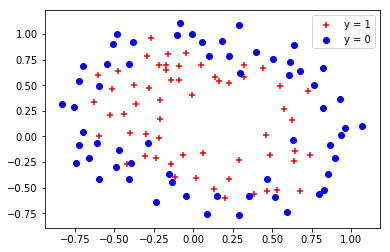

In [6]:
data = np.loadtxt("data/dataLR.txt", delimiter = ",")
X = np.c_[np.ones(len(data)),data[:,0:2]]
y = np.c_[data[:,2]]
def plotData(X, y):
    X1 = X[:,1:2]
    X2 = X[:,2:3]
    plt.scatter(X1[y==1], X2[y==1], color="red", marker = "+")
    plt.scatter(X1[y==0], X2[y==0], color = "blue", marker = "o")
    plt.legend(['y = 1', 'y = 0'])
plotData(X, y)

Observamos que es necesaria la creación de nuevas variables para separar las dos clases. <p>
Existen relaciones no lineales que nuestra hipótesis tiene que detectar. <p>
Vamos a generar todas las posibles combinaciones de variables con grado $\leq6$, es decir,

$x_{1}^{a}x_{2}^{b} \ \ \ \ \forall a,b \ \ \ \text{con } \ \ \ a+b \leq 6$ siendo $x_{1}, x_{2}$ las dos variables iniciales en los datos

Utilizamos la siguiente función

In [7]:
def mapFeature(X1, X2):        
    degree = 6
    X1 = np.reshape(X1,newshape= (np.size(X1),1))
    output = X1[:, 0:1]
    for i in range(1, degree + 1):
        for j in range(0, i + 1):              
                f = (X1** (i - j) * (X2 ** j))
                output = np.append(output, f, axis = 1)
    return output

#### Mapeamos los datos, obteniendo unos nuevos con 28 atributos

In [8]:
X_map = mapFeature(X[:,1:2], X[:,2:3])
print('La dimension de nuestro nuevo X es ', np.shape(X_map))

La dimension de nuestro nuevo X es  (118, 28)


Tomo parámetro regularizador C=100, calculo el coste inicial para un $\theta=[0,...,0]$(vector nulo)<p>
Posteriormente aplico el algoritmo del descenso del gradiente obteniendo el nuevo valor para $\theta$ y el coste mínimo.<p>
Realizo una gráfica con el valor del coste en función del número de iteraciones para asegurar la convergencia.

coste inicial [ 0.69314718]
coste final [ 0.53906799]


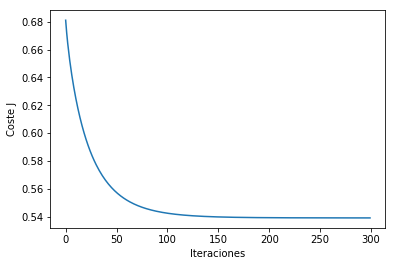

In [9]:
initial_theta = np.zeros(X_map.shape[1])
cost0 = computeCost(np.c_[np.ones(X_map.shape[0]), X_map], 
                    y, np.zeros(X_map.shape[1]+1), C=100)
print('coste inicial', cost0)
fit_parameters , Cost_J = gradientDescent(np.c_[np.ones(X_map.shape[0]),
                           X_map], y, np.zeros(X_map.shape[1]+1), C=100)
costF = computeCost(np.c_[np.ones(X_map.shape[0]), X_map],
                    y, fit_parameters, C=100)
print('coste final', costF)
plt.plot(Cost_J)
plt.ylabel('Coste J')
plt.xlabel('Iteraciones');

__Frontera de decisión__ <p>
Creamos una función que dibuje la frontera de decisión tomando $p=0.5$ <p>
$$y=1 \Leftrightarrow h_{\theta}(x)=g(\theta^{T}x) \geq \text{0.5} \Leftrightarrow \dfrac{1}{1+e^{-\theta^{T}x}}  \geq \text{0.5} \Leftrightarrow 1 \geq e^{-\theta^{T}x} \Leftrightarrow \theta^{T}x \geq 0$$
Dibujamos la curva de nivel que satisface $$z=\theta^{T}X=0$$


In [10]:
def plotBoundary(parameters):    
    u = np.linspace(-1, 1.5, 100)
    v = np.linspace(-1, 1.5, 100)
    z = np.zeros(shape=(len(u), len(v)))
    theta  = parameters[1:29].reshape(1,28)
    theta0 = parameters[0:1]   
    for i in range(len(u)):
        for j in range(len(v)):
            Xi = mapFeature(np.array(u[i]), np.array(v[j]))
            z[i, j] = np.dot(theta,Xi.T) + theta0
    z = z.T
    plt.contour(u, v, z, levels = [0])

Dibujamos la frontera de decisión asociada a los parámetros obtenidos con algoritmo. <p>
Aplico el mismo modelo con la librería scikit-learn para comparar resultados.

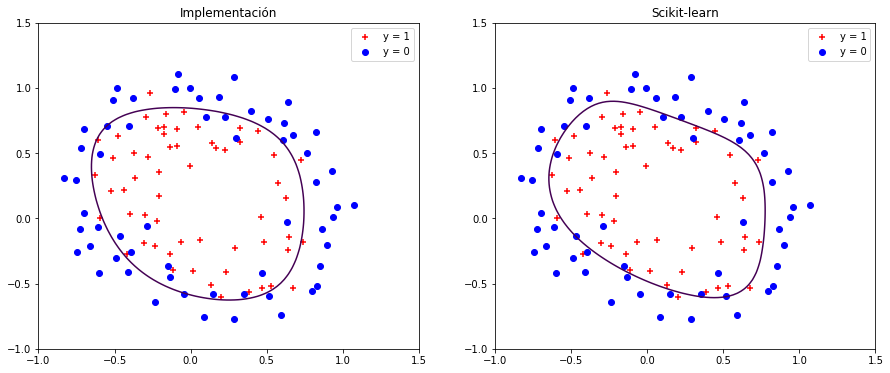

In [11]:
# Primera frontera de decisión (Nuestra implementación)

plt.figure(figsize=(15,6))
plt.subplot(121)
plotBoundary(fit_parameters)
plotData(X, y)
plt.title('Implementación');
plt.subplot(122)

# Modelo de regresión logística con scikit-learn

reg = linear_model.LogisticRegression(C=100, max_iter = 100, tol= 1e-8)
# Entrenamos el modelo con nuestros datos
reg.fit(X_map, np.ravel(y))
# Obtenemos los parámetros ajustados del modelo de regresión logística 
reg.densify()
reg.coef_ , reg.intercept_
fit_parameters = np.c_[reg.intercept_, reg.coef_][0]
# 
plotBoundary(fit_parameters)
plotData(X, y)
plt.title('Scikit-learn');

Podemos observar que son fronteras de decisión similares aunque scikit-learn lleva implementados algoritmos de optimización mucho más avanzados. <p>
Hemos sido capaz de implementar la regresión logística vectorizada con regularización! <p>
A partir de este momento, siempre que utilicemos la regresión logística será con scikit-learn. <p>

<p> </p>
<p> </p>
<p>

# Overfitting / Underfitting

Vamos a exponer un ejemplo de overfitting y otro de underfitting. Primero vamos con el de overfitting, tomamos C=100000. Dibujamos la frontera de decisión junto al nuevo punto que queremos clasificar.

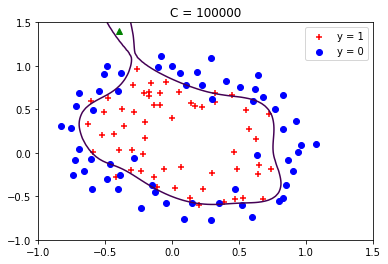

In [12]:
reg = linear_model.LogisticRegression(C=100000)
reg.fit(X_map, np.ravel(y))
reg.densify()
fit_parameters = np.c_[reg.intercept_, reg.coef_][0]
plotBoundary(fit_parameters)
plotData(X, y)
plt.plot([-0.4],[1.4], 'g^')
plt.title('C = %i' % 100000);

Observamos como la función hipótesis es demasiado compleja, es decir, ajusta muy bien los datos de entrenamiento pero en el caso de querer clasificar el nuevo punto $P=(-0.4, 1.4)$ (triangulo verde) lo hace de manera erronea ($\hat{y}=1$)

Ahora vamos con el ejemplo de underfitting, tomamos C=1/100

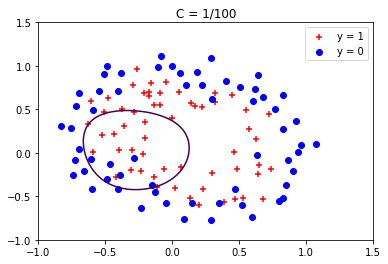

In [13]:
reg = linear_model.LogisticRegression(C=1/100)
reg.fit(X_map, np.ravel(y))
fit_parameters = np.c_[reg.intercept_, reg.coef_][0]
plotBoundary(fit_parameters)
plotData(X, y)
plt.title('C = 1/100');

En este caso, nuestra frontera de decisión no separa las clases correctamente. Nuestro modelo tiene alto sesgo.